# Part 2: Prediction

It's time to deploy our model to find Syd. Happy Hunting :)

![wanted Syd](https://raw.githubusercontent.com/floydhub/object-detection-template/master/images/wanted-syd.jpg)

**IMPORTANT**

To not waste GPU time, run this notebook on a CPU instance if you are interested in only a single evaluation test.

For more info about Tensorflow Object Detection, please refer to [the official docs](https://github.com/tensorflow/models/tree/master/research/object_detection/g3doc).

## Initial Setup
Let's start by importing the packages and loading the exported model.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sys
import tensorflow as tf
import matplotlib
from PIL import Image
import matplotlib.patches as patches
import argparse
import os

import sys
sys.path.append("slim")

MODEL_PATH = '/floyd/home/trained_models/ssdlite_mobilenet_v2_coco_2018_05_09_exported/frozen_inference_graph.pb'
IMAGE_PATH = '/floyd/input/syd/images/'

In [2]:
# Utility function
def draw_box(box, image_np):
    """Draw a box around the Syd predicted position"""
    #expand the box by 50%
    box += np.array([-(box[2] - box[0])/2, -(box[3] - box[1])/2, (box[2] - box[0])/2, (box[3] - box[1])/2]) 

    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)

    #draw blurred boxes around box
    ax.add_patch(patches.Rectangle((0,0),box[1]*image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[3]*image_np.shape[1],0),image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[1]*image_np.shape[1],0),(box[3]-box[1])*image_np.shape[1], box[0]*image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))
    ax.add_patch(patches.Rectangle((box[1]*image_np.shape[1],box[2]*image_np.shape[0]),(box[3]-box[1])*image_np.shape[1], image_np.shape[0],linewidth=0,edgecolor='none',facecolor='w',alpha=0.8))

    return fig, ax

# From PIL Image to numpy tensor
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Visualizing Test samples

Run the code Cell below and play with the slider to plot the prediction on the test images.

**Note**

Images are pixelled because are resized.

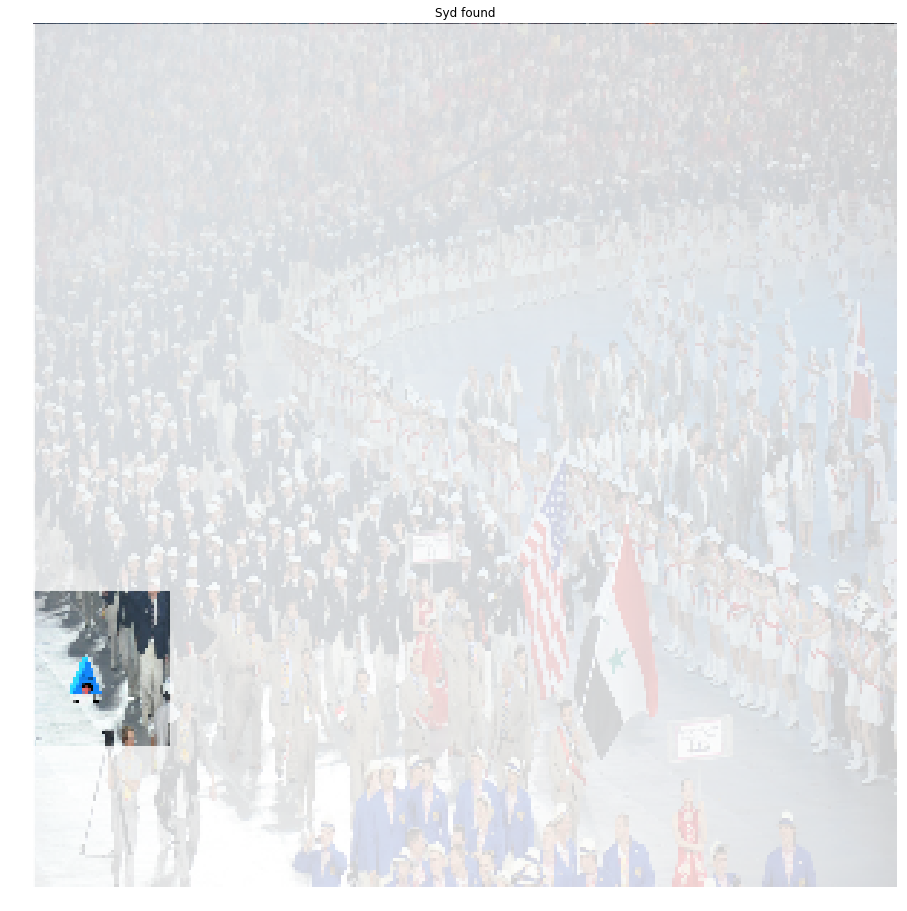

In [3]:
from ipywidgets import interact
from ipywidgets import widgets

# Load the graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

def show_sample(sample_n):
    with detection_graph.as_default():
        # Which test load
        test = 'test.jpg' if sample_n == 1 else 'test2.jpg'
        image_path = os.path.join(IMAGE_PATH, test)
        with tf.Session(graph=detection_graph) as sess:
            # Preprocessing
            image = Image.open(image_path).resize((300, 300)) # Resize image (prevent OOM)
            image_np = load_image_into_numpy_array(image)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: np.expand_dims(image_np, axis=0)})
            
            # Found?
            if scores[0][0] < 0.1:
                sys.exit('Syd not found :(')
            
            # Plot
            fig, ax = draw_box(boxes[0][0], image_np)
            fig.set_size_inches(12, 12)
            ax.set_title('Syd found')
            ax.imshow(image_np)
            plt.axis('off')
            plt.show()
    
interact(show_sample, sample_n=widgets.IntSlider(value=2, min=1, max=2, description='Show test sample'));

Not bad, but there is still room for improvements! Even with only few samples, the model is able to detect Syd when it appears in open spot, it's not so small in the image and it's not camouflaged with the background.

## Visualizing Train samples

Run the code Cell below and play with the slider to plot the prediction on the train images.

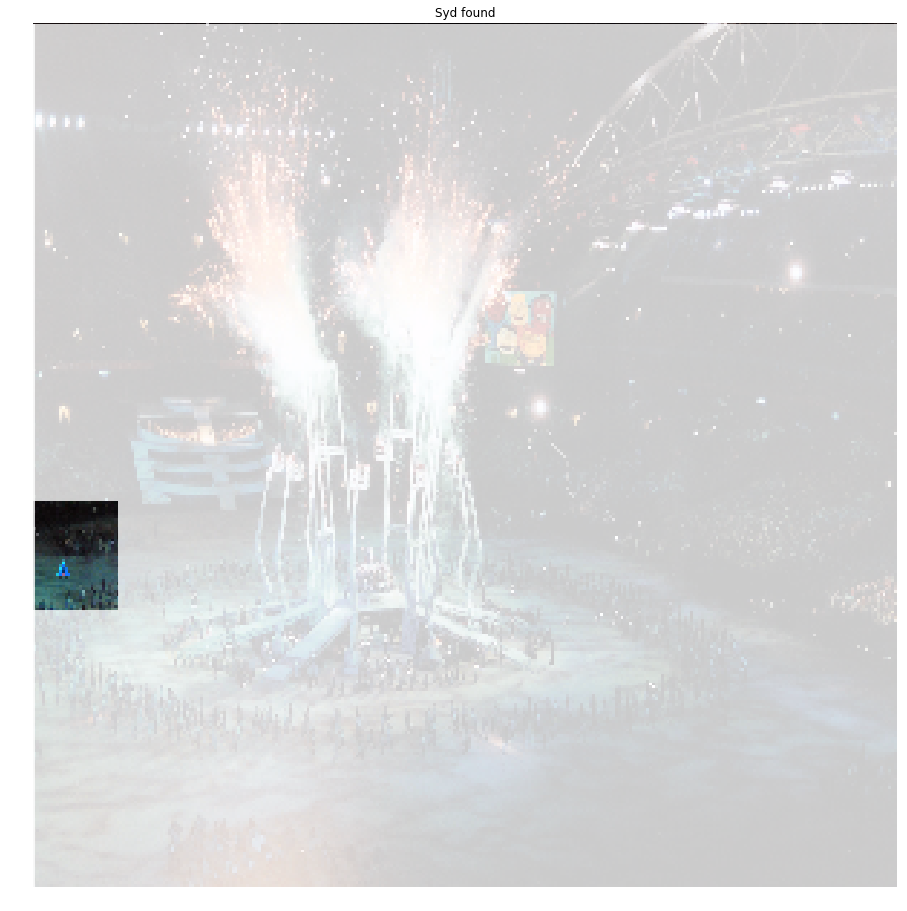

In [4]:
def show_sample(sample_n):
    with detection_graph.as_default():
        # Which test load
        image_path = os.path.join(IMAGE_PATH, str(sample_n) + '.jpg')
        with tf.Session(graph=detection_graph) as sess:
            # Preprocessing
            image = Image.open(image_path).resize((300, 300)) # Resize image (prevent OOM)
            image_np = load_image_into_numpy_array(image)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: np.expand_dims(image_np, axis=0)})
            
            # Found?
            if scores[0][0] < 0.1:
                sys.exit('Syd not found :(')
            
            # Plot
            fig, ax = draw_box(boxes[0][0], image_np)
            fig.set_size_inches(12, 12)
            ax.set_title('Syd found')
            ax.imshow(image_np)
            plt.axis('off')
            plt.show()
    
interact(show_sample, sample_n=widgets.IntSlider(value=1, min=1, max=10, description='Show train sample'));

Here's what you can do for improving the results:
- Train longer
- Add more data
- Change another model